[Go to this directory index](./)

Contents
  - [More optimization trials¶](#More-optimization-trials)
      - [Trial 2.1¶](#Trial-2.1)
      - [Trial 2.2¶](#Trial-2.2)
        - [Aside¶](#Aside)
      - [Trial 2.3¶](#Trial-2.3)

# More optimization trials

Previously, I tried throwing a bunch of optimizers at my model. I liked the results from the scipy.optimize routines COBYLA and BFGS. Let's try adjusting how we handle the constraints, and see if we get better results.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import numpy
from IPython.display import HTML, SVG

In [3]:
#matplotlib.use('svg')
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.sans-serif'] = 'Arial'

In [4]:
from io import BytesIO
def pltsvg():
    imgdata = BytesIO()
    plt.savefig(imgdata)
    imgdata.seek(0)
    display(SVG(data=imgdata.read()))

### Trial 2.1

In general, here is how we compute the modified objective function. GenOpt manual suggests adding functions to the objective, namely separate barrier (B) and penalty (P) functions. The objective function is, with step number as $k$,

$$ Objective = -Q_{cooling}(x) + \mu_1 B(x) + \mu_2 P(x) $$

$$ \mu_1 = k^{-2}$$
$$ B(x) = \left(\sum_{j=1}^{N_B} g_j(x) \right) ^ {-1} $$

$$\mu_2 = k^{2}$$
$$ P(x) = \sum_{j=N_B+1}^{N_B + N_P} g_j(x)$$

GenOpt implements a mechanism to pass in the step number. However, using the scipy.optimize routines, passing in the step number is a challenge, so the `Problem` object should probably use its own counter of function calls. This could be quirky, since then the objective function is changing with each call. Some routines allow for termination after a number of steps, so we could run a while, increment step number, then continue.

But we need to make some decisions.

- Which constraints should be handled by barriers, and which by penalties?
  - Use barriers for hard constraints, eg. required for feasibility of the chiller model
  - Use penalties for soft constraints, eg. heat exchange feasibility that can be violated now and satisfied later
- With scipy.optimize, we can directly apply constraints on the input variables (such as $T_1 > T_2$)



In [26]:
def saturate(x, bottom=-numpy.inf, top=0):
    a_bottom = numpy.empty_like(x)
    a_top = numpy.empty_like(x)
    a_bottom.fill(bottom)
    a_top.fill(top)
    return numpy.minimum(a_top,
                         numpy.maximum(a_bottom,
                                       x))

def barrier1(c, length_scale):
    """The domain for B is the feasible set only.
    We want B large near boundary, but small elsewhere.
    Feasible means c > 0 and g < 0. Please input c.
    """
    g = numpy.negative(c)
    b = numpy.exp(g / length_scale)
    return numpy.sum(b)

def penalty1(c, length_scale):
    """We want P = 0 for feasible, P > 0 elsewhere
    Feasible means c > 0 and g < 0.
    """
    g = numpy.negative(c)
    g = saturate(g,bottom=0,top=numpy.inf)
    p = (g / length_scale)**2
    return numpy.sum(p)

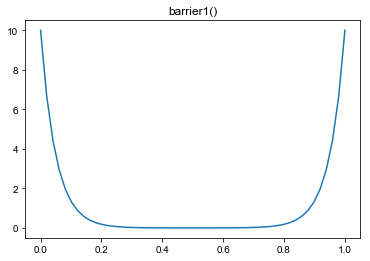

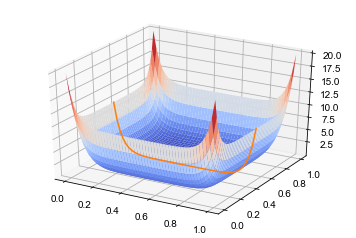

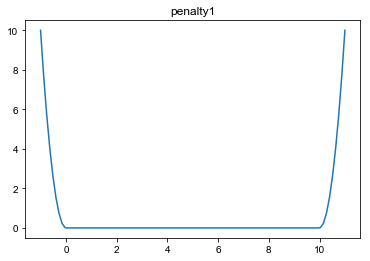

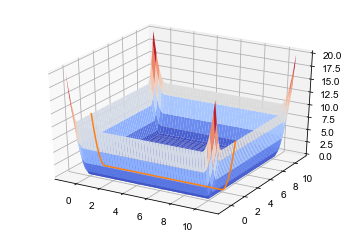

In [91]:
# Demo barriers
xx = numpy.linspace(0,1)
yy = numpy.linspace(0,1)
X, Y = numpy.meshgrid(xx,yy)
B = numpy.zeros_like(X)
mu_B = 10
for i, (xi,yi) in enumerate(zip(X.flat,Y.flat)):
    # The domain for B is the feasible set only.
    # We want B large near boundary, but small elsewhere.
    # Feasible means c > 0 and g < 0.
    c = numpy.array([xi, yi, (1-xi), (1-yi)])
    # The length scale for the barrier
    dx = 0.05
    B.flat[i] = mu_B * barrier1(c,dx)

plt.close('all')
fig = plt.figure()
plt.plot(X[25],B[25])
plt.title("barrier1()")
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,B,cmap=cm.coolwarm)
ax.plot(X[25],Y[25],B[25])
#pltsvg()
plt.show()

xx = numpy.linspace(-1,11)
yy = numpy.linspace(-1,11)
X, Y = numpy.meshgrid(xx,yy)
P = numpy.zeros_like(X)

mu_P = 10
for i, (xi,yi) in enumerate(zip(X.flat,Y.flat)):
    # We want P = 0 for feasible, P > 0 elsewhere
    # Feasible means c > 0 and g < 0.
    c = numpy.array([xi, yi, (10-xi), (10-yi)])
    # The length scale for the penalty
    dx = 1
    P.flat[i] = mu_P * penalty1(c, dx)

plt.close('all')
fig = plt.figure()
plt.plot(X[25],P[25])
plt.title("penalty1")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,P,cmap=cm.coolwarm)
ax.plot(X[25],Y[25],P[25])
#pltsvg()
plt.show()


In [87]:
step_number = 140
mu_B = 100. * numpy.exp(0.01 * step_number)
mu_B

405.51999668446751

In [68]:
import ammonia1
import system_aqua1
import scipy.optimize

class Problem_2_1:
    def __init__(self, bdry, UAgoal, mu=0.1):
        self.bdry = bdry
        self.UAgoal = UAgoal
        self.mu = mu
        self.Ncons = 7
        self.n_calls = 0
        # Soft constraints mode: this is sent to minimizer
        self.constraints = [{'type': 'ineq',
                             'fun': self.constraint,
                             'args': (i,)
                            } for i in range(self.Ncons)]
            
    def objective(self, xC):
        step_number = numpy.floor(self.n_calls / 7)
        self.n_calls += 1
        print(xC,flush=True)
        Q,B,P = 0.,0.,0.
        try:
            ch = system_aqua1.makeChiller(xC)
            sys = system_aqua1.System(self.bdry, ch)
            
            # Barriers
            # Magnitude tends to zero, slowly
            mu_B = 1000. * numpy.exp(-0.2 * step_number)
            
            # These are zero at the boundary ...
            barriers = [ch.check_rectifier_delta_T] \
                        + [deltaT
                           for name, deltaT, epsilon, UA, Qhx in sys.data]
            B = mu_B * barrier1(barriers,1)
            
            # Penalties
            # Magnitude tends to infinite, bit more quickly
            mu_P = 0.01 * numpy.exp(0.01 * step_number)
            penalties = [-(1.0 - sys.totalUA/self.UAgoal)]
            P = mu_P * penalty1(penalties,1)
            
            Q = sys.chiller.Q_evap
        except:
            Q = numpy.inf
        
        print(self.n_calls, step_number, Q, B, P, "\n", flush=True)
        return -Q + B + P
    
    def constraint(self, x, *args):
        cons = [x[0] - 0.1,
                1. - x[0],
                x[2] - x[1] - 1.0,
                x[3] - x[2] - 1.0,
                x[4] - x[1] - 10.0,
                x[5] - x[3] - 1.0,
                x[5] - x[4] - 1.0]
        if len(args) > 0:
            i, = args
            return cons[i]
        else:
            return cons

    def callback(self, x):
        print("Did an iteration at ", x)

In [69]:
T_heat_reject = 305.
UAgoal = 100
xB = [400, 1, T_heat_reject, 3, T_heat_reject, 5, 285, 4, T_heat_reject, 0.15]
bdry = system_aqua1.makeBoundary(xB)
P = Problem_2_1(bdry, UAgoal)

In [70]:
rT = T_heat_reject
x = numpy.array([0.05, 278.45, rT+7, rT+8, rT+5, 395.15])

In [58]:
x = numpy.array([0.51284472, 277.97717012, 312.16427764, 313.6952877,
               310.24856734, 374.14020482])

In [81]:
P.n_calls = 7 * numpy.floor(P.n_calls / 7)
opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                              constraints=P.constraints, callback=P.callback,
                              options={'disp':True,'maxiter':1000,'rhobeg':0.1})
opt

[  3.51310459e-01   2.78076946e+02   3.12446276e+02   3.13507665e+02
   3.11046022e+02   3.95302768e+02]


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\optimize\_minimize.py:403: RuntimeWarning: Method COBYLA does not support callback.
  warn('Method %s does not support callback.' % method, RuntimeWarning)
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


Note: Absorber inlet is subcooled
218.0 31.0 121.3153108 2.37779810091 0.0 

[   0.45131046  278.0769459   312.4462762   313.50766508  311.04602226
  395.30276837]


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Note: Absorber inlet is subcooled
219.0 31.0 155.847533671 701880.652353 0.0 

[  3.51310459e-01   2.78176946e+02   3.12446276e+02   3.13507665e+02
   3.11046022e+02   3.95302768e+02]
Note: Absorber inlet is subcooled
220.0 31.0 121.751810144 2.48406368814 0.0 

[  3.51310459e-01   2.78176946e+02   3.12546276e+02   3.13507665e+02
   3.11046022e+02   3.95302768e+02]
Note: Absorber inlet is subcooled
221.0 31.0 121.48910841 2.46032801796 0.0 

[  3.51310459e-01   2.78176946e+02   3.12446276e+02   3.13607665e+02
   3.11046022e+02   3.95302768e+02]
Note: Absorber inlet is subcooled
222.0 31.0 121.751810144 2.48401066386 0.0 

[  3.51310459e-01   2.78176946e+02   3.12446276e+02   3.13607665e+02
   3.11146022e+02   3.95302768e+02]
Note: Absorber inlet is subcooled
223.0 31.0 121.363069612 2.4387336067 0.0 

[  3.51310459e-01   2.78176946e+02   3.12446276e+02   3.13607665e+02
   3.11046022e+02   3.95402768e+02]
Note: Absorber inlet is subcooled
224.0 31.0 121.928163983 2.59636753391 0.0 

[  

Note: Absorber inlet is subcooled
264.0 37.0 126.793444795 2.78142871926 0.0 

[  3.64158318e-01   2.78201565e+02   3.12409066e+02   3.13641259e+02
   3.11011883e+02   3.95430710e+02]
Note: Absorber inlet is subcooled
265.0 37.0 126.788307424 2.78280354438 0.0 

[  3.65656771e-01   2.78203146e+02   3.12408910e+02   3.13641259e+02
   3.11012063e+02   3.95430361e+02]
Note: Absorber inlet is subcooled
266.0 37.0 127.316255119 3.30297535062 0.0 

[  3.65890818e-01   2.78203172e+02   3.12408739e+02   3.13641259e+02
   3.11011412e+02   3.95430043e+02]
Note: Absorber inlet is subcooled
267.0 38.0 127.400392615 2.77814971195 0.0 

[  3.65947179e-01   2.78203117e+02   3.12408045e+02   3.13641259e+02
   3.11011082e+02   3.95430162e+02]
Note: Absorber inlet is subcooled
268.0 38.0 127.423210294 2.79661739278 0.0 

[  3.65987640e-01   2.78202732e+02   3.12408062e+02   3.13641259e+02
   3.11011101e+02   3.95430113e+02]
Note: Absorber inlet is subcooled
269.0 38.0 127.435339123 2.80948535326 0.0 

[

Note: Absorber inlet is subcooled
309.0 44.0 130.407485108 2.35928445666 0.0 

[  3.74509238e-01   2.78204228e+02   3.12404646e+02   3.13640868e+02
   3.11003530e+02   3.95426700e+02]
Note: Absorber inlet is subcooled
310.0 44.0 130.444019941 2.38814560803 0.0 

[  3.74546945e-01   2.78203841e+02   3.12404664e+02   3.13640868e+02
   3.11003550e+02   3.95426665e+02]
Note: Absorber inlet is subcooled
311.0 44.0 130.455154179 2.39934333673 0.0 

[  3.74684716e-01   2.78204304e+02   3.12404566e+02   3.13640868e+02
   3.11003439e+02   3.95425952e+02]
Note: Absorber inlet is subcooled
312.0 44.0 130.504691055 2.44034617931 0.0 

[  3.74684716e-01   2.78204304e+02   3.12404566e+02   3.13641259e+02
   3.11003439e+02   3.95425952e+02]
Note: Absorber inlet is subcooled
313.0 44.0 130.50469097 2.44034609652 0.0 

[  3.74874915e-01   2.78204296e+02   3.12404910e+02   3.13640868e+02
   3.11002769e+02   3.95426036e+02]
Note: Absorber inlet is subcooled
314.0 44.0 130.572879976 2.5001456631 0.0 

[  

Note: Absorber inlet is subcooled
354.0 50.0 133.795586357 2.44670106147 0.0 

[  3.84016506e-01   2.78205454e+02   3.12400936e+02   3.13641259e+02
   3.10996061e+02   3.95422479e+02]
Note: Absorber inlet is subcooled
355.0 50.0 133.795586353 2.44670105841 0.0 

[  3.84246473e-01   2.78205450e+02   3.12401282e+02   3.13640868e+02
   3.10995405e+02   3.95422572e+02]
Note: Absorber inlet is subcooled
356.0 50.0 133.877673678 2.52193065707 0.0 

[  3.84595448e-01   2.78205484e+02   3.12401302e+02   3.13640868e+02
   3.10995551e+02   3.95422662e+02]
Note: Absorber inlet is subcooled
357.0 50.0 133.998914491 2.64013522519 0.0 

[  3.85177259e-01   2.78205577e+02   3.12401041e+02   3.13640868e+02
   3.10995157e+02   3.95422464e+02]
Note: Absorber inlet is subcooled
358.0 51.0 134.204124128 2.33275781092 0.0 

[  3.85319698e-01   2.78205531e+02   3.12400349e+02   3.13640868e+02
   3.10994855e+02   3.95422598e+02]
Note: Absorber inlet is subcooled
359.0 51.0 134.257065723 2.37707474161 0.0 

[

Note: Absorber inlet is subcooled
399.0 56.0 137.207302316 2.63017859794 0.0 

[  3.94192498e-01   2.78207148e+02   3.12396885e+02   3.13640868e+02
   3.10987443e+02   3.95418831e+02]
Note: Absorber inlet is subcooled
400.0 57.0 137.391648477 2.30720288926 0.0 

[  3.94358119e-01   2.78207104e+02   3.12396195e+02   3.13640868e+02
   3.10987152e+02   3.95418971e+02]
Note: Absorber inlet is subcooled
401.0 57.0 137.452737014 2.35882335423 0.0 

[  3.94409540e-01   2.78206727e+02   3.12396208e+02   3.13640868e+02
   3.10987166e+02   3.95418885e+02]
Note: Absorber inlet is subcooled
402.0 57.0 137.468540577 2.37463455338 0.0 

[  3.94590395e-01   2.78207294e+02   3.12396114e+02   3.13640868e+02
   3.10987082e+02   3.95418258e+02]
Note: Absorber inlet is subcooled
403.0 57.0 137.533762584 2.4312996419 0.0 

[  3.94590395e-01   2.78207294e+02   3.12396114e+02   3.13641259e+02
   3.10987082e+02   3.95418258e+02]
Note: Absorber inlet is subcooled
404.0 57.0 137.53376262 2.43129967804 0.0 

[  

Note: Absorber inlet is subcooled
448.0 63.0 140.938240678 2.63171657939 0.0 

[   0.40469441  278.20907846  312.39184527  313.6408683   310.97855859
  395.41464647]
Note: Absorber inlet is subcooled
449.0 64.0 141.108252458 2.2964322062 0.0 

[   0.40487785  278.20903616  312.39115684  313.6408683   310.978276
  395.4147918 ]
Note: Absorber inlet is subcooled
450.0 64.0 141.17563702 2.35370486632 0.0 

[   0.40493052  278.20866019  312.3911692   313.6408683   310.97829003
  395.41470171]
Note: Absorber inlet is subcooled
451.0 64.0 141.191828159 2.36990134946 0.0 

[   0.40512495  278.20923515  312.39107636  313.6408683   310.97821375
  395.41408516]
Note: Absorber inlet is subcooled
452.0 64.0 141.261890459 2.43114407825 0.0 

[   0.40512495  278.20923515  312.39107637  313.64125893  310.97821375
  395.41408516]
Note: Absorber inlet is subcooled
453.0 64.0 141.261890507 2.43114412667 0.0 

[   0.40538859  278.20923506  312.39142328  313.6408683   310.97757344
  395.4141876 ]
Note: Ab

Note: Absorber inlet is subcooled
498.0 71.0 144.825124952 2.29296735066 0.0 

[   0.41538246  278.21103276  312.38600327  313.6408683   310.96951727
  395.41067602]
Note: Absorber inlet is subcooled
499.0 71.0 144.896481195 2.35381760013 0.0 

[   0.41543608  278.21065756  312.38601533  313.6408683   310.96953107
  395.41058328]
Note: Absorber inlet is subcooled
500.0 71.0 144.912952968 2.37029349308 0.0 

[   0.41563844  278.21123822  312.38592338  313.6408683   310.96946002
  395.40997391]
Note: Absorber inlet is subcooled
501.0 71.0 144.985885601 2.43426681517 0.0 

[   0.41563844  278.21123822  312.38592338  313.64125892  310.96946002
  395.40997391]
Note: Absorber inlet is subcooled
502.0 71.0 144.985885653 2.43426686749 0.0 

[   0.41590921  278.21123879  312.38627091  313.6408683   310.96882339
  395.41007861]
Note: Absorber inlet is subcooled
503.0 71.0 145.082415248 2.52438384753 0.0 

[   0.41623528  278.21126671  312.38631276  313.6408683   310.96900265
  395.41018628]
Note

Note: Absorber inlet is subcooled
548.0 78.0 148.616415384 2.35496457799 0.0 

[   0.42592993  278.21270256  312.38079688  313.64086829  310.96085656
  395.40651636]
Note: Absorber inlet is subcooled
549.0 78.0 148.633101691 2.37165420562 0.0 

[   0.42613678  278.21328748  312.38070555  313.6408683   310.96078881
  395.40591213]
Note: Absorber inlet is subcooled
550.0 78.0 148.707706207 2.43722039539 0.0 

[   0.42613678  278.21328748  312.38070555  313.64125892  310.96078881
  395.40591213]
Note: Absorber inlet is subcooled
551.0 78.0 148.707706261 2.43722044917 0.0 

[   0.42641176  278.21328844  312.38105349  313.64086829  310.96015444
  395.40601822]
Note: Absorber inlet is subcooled
552.0 78.0 148.805790942 2.52896884636 0.0 

[   0.4267348   278.21331566  312.38109822  313.64086829  310.96033739
  395.40612788]
Note: Absorber inlet is subcooled
553.0 78.0 148.917893244 2.6406586684 0.0 

[   0.42717159  278.21341306  312.38072237  313.64086829  310.95988075
  395.40588231]
Note:

[   0.43641377  278.21478603  312.37554179  313.64086829  310.95223636
  395.40248666]
Note: Absorber inlet is subcooled
598.0 85.0 152.352851446 2.3729044831 0.0 

[   0.43662304  278.2153743   312.37545088  313.64086829  310.95217066
  395.40188623]
Note: Absorber inlet is subcooled
599.0 85.0 152.428405746 2.43937129544 0.0 

[   0.43662304  278.21537429  312.37545089  313.64125892  310.95217066
  395.40188623]
Note: Absorber inlet is subcooled
600.0 85.0 152.428405801 2.43937134986 0.0 

[   0.43690054  278.21537549  312.37579908  313.64125891  310.95153768
  395.40199317]
Note: Absorber inlet is subcooled
601.0 85.0 152.527455365 2.53212762257 0.0 

[   0.43722169  278.21540226  312.3758456   313.64125891  310.95172284
  395.40210402]
Note: Absorber inlet is subcooled
602.0 85.0 152.638910818 2.64333209523 0.0 

[   0.43764957  278.21550064  312.37546321  313.64125891  310.95126411
  395.40185717]
Note: Absorber inlet is subcooled
603.0 86.0 152.791756841 2.29149413853 0.0 

[   0

Note: Absorber inlet is subcooled
647.0 92.0 156.072557642 2.37385898945 0.0 

[   0.44709904  278.21749336  312.37017545  313.64125891  310.94358403
  395.39788548]
Note: Absorber inlet is subcooled
648.0 92.0 156.14862336 2.44080325028 0.0 

[   0.44709904  278.21749337  312.37017545  313.64086829  310.94358403
  395.39788548]
Note: Absorber inlet is subcooled
649.0 92.0 156.148623305 2.44080319573 0.0 

[   0.44737804  278.21749471  312.3705238   313.64086829  310.94295188
  395.39799293]
Note: Absorber inlet is subcooled
650.0 92.0 156.248285402 2.53419084865 0.0 

[   0.44769803  278.2175212   312.37057142  313.64086829  310.94313837
  395.3981045 ]
Note: Absorber inlet is subcooled
651.0 92.0 156.359356367 2.64511151183 0.0 

[   0.44812029  278.21762066  312.37018525  313.64086829  310.94267816
  395.39785701]
Note: Absorber inlet is subcooled
652.0 93.0 156.510405888 2.29142563958 0.0 

[   0.44832871  278.21758073  312.36949986  313.64086829  310.94240995
  395.39801068]
Note:

[   0.4575659   278.21964136  312.36488871  313.64125891  310.93501435
  395.39390237]
Note: Absorber inlet is subcooled
697.0 99.0 159.868762746 2.44171813222 0.0 

[   0.4575659   278.21964136  312.36488871  313.64086829  310.93501436
  395.39390237]
Note: Absorber inlet is subcooled
698.0 99.0 159.868762692 2.4417180777 0.0 

[   0.45784578  278.2196428   312.36523716  313.64086828  310.9343827
  395.39401012]
Note: Absorber inlet is subcooled
699.0 99.0 159.968823339 2.53550675435 0.0 

[   0.45816508  278.21966913  312.36528542  313.64086828  310.93456997
  395.39412212]
Note: Absorber inlet is subcooled
700.0 99.0 160.079676417 2.6462724165 0.0 

[   0.45858373  278.21976971  312.3648972   313.64086828  310.9341086
  395.39387435]
Note: Absorber inlet is subcooled
701.0 100.0 160.229626608 2.29143447043 0.0 

[   0.45879355  278.21972993  312.364212    313.64086828  310.93384123
  395.39402852]
Note: Absorber inlet is subcooled
702.0 100.0 160.306764962 2.35750947071 0.0 

[   0.

Note: Absorber inlet is subcooled
746.0 106.0 163.589082936 2.44228905948 0.0 

[   0.46802432  278.22181619  312.35959637  313.64125891  310.92645216
  395.38993195]
Note: Absorber inlet is subcooled
747.0 106.0 163.589082991 2.44228911424 0.0 

[   0.4683047   278.22181769  312.35994487  313.6412589   310.92582079
  395.39003987]
Note: Absorber inlet is subcooled
748.0 106.0 163.689410677 2.53633657699 0.0 

[   0.46862361  278.22184392  312.3599935   313.6412589   310.9260085
  395.3901521 ]
Note: Absorber inlet is subcooled
749.0 106.0 163.800151081 2.64702886225 0.0 

[   0.4690399   278.22194567  312.35960427  313.6412589   310.92554614
  395.38990426]
Note: Absorber inlet is subcooled
750.0 107.0 163.949433655 2.2914734682 0.0 

[   0.4692505   278.22190598  312.35891919  313.64125891  310.92527926
  395.39005873]
Note: Absorber inlet is subcooled
751.0 107.0 164.026963199 2.35790042602 0.0 

[   0.46930701  278.22153313  312.35893037  313.64125891  310.92529248
  395.38995833]


795.0 113.0 167.309751758 2.44263925712 0.0 

[   0.47847475  278.22401652  312.35430188  313.64125891  310.91789141
  395.38597101]
Note: Absorber inlet is subcooled
796.0 113.0 167.309751812 2.44263931153 0.0 

[   0.4787554   278.22401806  312.3546504   313.6412589   310.91726019
  395.38607902]
Note: Absorber inlet is subcooled
797.0 113.0 167.410265142 2.53685727461 0.0 

[   0.4790741   278.22404424  312.35469924  313.6412589   310.91744814
  395.38619138]
Note: Absorber inlet is subcooled
798.0 113.0 167.52095907 2.64752761557 0.0 

[   0.47948879  278.22414718  312.35430964  313.6412589   310.91698489
  395.38594359]
Note: Absorber inlet is subcooled
799.0 114.0 167.669842906 2.29152641244 0.0 

[   0.47969981  278.22410756  312.35362463  313.6412589   310.91671825
  395.38609821]
Note: Absorber inlet is subcooled
800.0 114.0 167.747632641 2.35818612586 0.0 

[   0.47975673  278.22373505  312.35363569  313.6412589   310.91673139
  395.38599675]
Note: Absorber inlet is subcooled

[   0.48891746  278.22624153  312.34900736  313.64086828  310.90932831
  395.38201756]
Note: Absorber inlet is subcooled
845.0 120.0 171.030878892 2.44285050717 0.0 

[   0.48919823  278.2262431   312.34935588  313.64086827  310.90869715
  395.38212561]
Note: Absorber inlet is subcooled
846.0 120.0 171.131527314 2.5371840567 0.0 

[   0.48951684  278.22626926  312.34940481  313.64086827  310.9088852
  395.38223802]
Note: Absorber inlet is subcooled
847.0 120.0 171.242216293 2.64786472637 0.0 

[   0.48993043  278.22637341  312.34901526  313.64086827  310.90842113
  395.38199035]
Note: Absorber inlet is subcooled
848.0 121.0 171.390869295 2.29158738914 0.0 

[   0.49014163  278.22633383  312.34833028  313.64086828  310.90815459
  395.38214505]
Note: Absorber inlet is subcooled
849.0 121.0 171.468837554 2.35840542542 0.0 

[   0.49019894  278.22596166  312.34834122  313.64086827  310.90816766
  395.38204256]
Note: Absorber inlet is subcooled
850.0 121.0 171.486257099 2.37582689818 0.0 



Note: Absorber inlet is subcooled
894.0 127.0 174.659735549 2.35857444916 0.0 

[   0.49937496  278.22809248  312.34402055  313.64125889  310.89995237
  395.37796103]
Note: Absorber inlet is subcooled
895.0 127.0 174.760937955 2.45014409238 0.0 

[   0.49905637  278.22806633  312.34397161  313.64125889  310.89976429
  395.3778486 ]
Note: Absorber inlet is subcooled
896.0 127.0 174.650227759 2.34770937208 0.0 

[   0.50010788  278.22816717  312.34381552  313.64125889  310.89980532
  395.37789836]
Note: Absorber inlet is subcooled
897.0 128.0 175.019320686 2.21318668676 0.0 

[   0.50032958  278.22812663  312.34313237  313.6412589   310.89954633
  395.37805892]
Note: Absorber inlet is subcooled
898.0 128.0 175.101037159 2.28102262523 0.0 

[   0.50028826  278.22850951  312.34311675  313.6412589   310.89953037
  395.37812046]
Note: Absorber inlet is subcooled
899.0 128.0 175.089258551 2.26910370353 0.0 

[   0.50057728  278.22864968  312.34303979  313.6412589   310.89948946
  395.37741366

943.0 134.0 178.418847893 2.39636893945 0.0 

[   0.50994878  278.23012793  312.33913617  313.64086827  310.89190568
  395.37419316]
Note: Absorber inlet is subcooled
944.0 134.0 178.528740678 2.49775093673 0.0 

[   0.5102468   278.23015144  312.3392008   313.64086827  310.89211482
  395.37431687]
Note: Absorber inlet is subcooled
945.0 134.0 178.632107962 2.59956955281 0.0 

[   0.51080642  278.23023866  312.33885821  313.64086827  310.89175079
  395.37411767]
Note: Absorber inlet is subcooled
946.0 135.0 178.831437791 2.29439869678 0.0 

[   0.51105879  278.2302011   312.33818116  313.64086827  310.89151016
  395.37428782]
Note: Absorber inlet is subcooled
947.0 135.0 178.923928327 2.37456888462 0.0 

[   0.51110797  278.22982239  312.33819512  313.64086827  310.89152537
  395.37420834]
Note: Absorber inlet is subcooled
948.0 135.0 178.938393167 2.38947652443 0.0 

[   0.51136843  278.23038318  312.33810953  313.64086827  310.89148381
  395.37359826]
Note: Absorber inlet is subcoole

     fun: -178.85043263341649
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 765
  status: 1
 success: True
       x: array([   0.51504584,  278.23064509,  312.3360942 ,  313.64070465,
        310.88891373,  395.37315265])

In [82]:
x = opt.x
x

array([   0.51504584,  278.23064509,  312.3360942 ,  313.64070465,
        310.88891373,  395.37315265])

In [ ]:
# Let's bebug bad points encountered during optimization.
# For reference, here is a good case.
good_X1 = numpy.array([0.51284472,
                       277.97717012,
                       312.16427764,
                       313.6952877,
                       310.24856734,
                       374.14020482])
# Now, let's compare some degenerate cases.
# This one requires absorber stream to compute points at high concentrations.
bad_X1 = numpy.array([0.2,
                      290.95402556,
                      306.64229519,
                      313.6952877,
                      300.86211291,
                      384.36256216])
# This one is not feasible, insofar as it yields positive rectifier heat flow,
# that is, heat *input* to rectifier, which should be rejected as "bad" design.
# The cause is that T_abs is very low, so the rich stream is very rich,
# and in fact the rectifier isn't needed...
# So, I'm adding a constraint to keep the absorber warmer than evaporator.
bad_X2 = numpy.array([1.,
                      293.03582607,
                      308.98651075,
                      313.6952877,
                      293.29251019,
                      386.99474])
# This one is also degenerate in the rectifier.
# Try increasing the padding on the constraints.
bad_X3 = numpy.array([1.,
                      292.26696584,
                      301.95207453,
                      314.19203364,
                      293.26696584,
                      389.23622472])
bad_X4 = numpy.array([1.,
                      277.22895294,
                      278.22895294,
                      308.37781922,
                      282.22895294,
                      417.08853392])
x = good_X1

In [83]:
ch = system_aqua1.makeChiller(x)
display(ch)
P.constraint(x)

,T,P,x,h,s,u,v,Qu
rich_abs_outlet,310.889,4.91932,0.509697,-70.4046,0.404632,-71.0096,0.00122988,0
rich_pump_outlet,311.054,15.2125,0.509697,-68.8224,0.405649,-70.6927,0.0012294,-0.001
rich_shx_outlet,351.109,15.2125,0.509697,114.344,0.959321,112.364,0.00130108,-0.001
rich_gen_sat_liquid,352.535,15.2125,0.509697,121.481,0.97973,119.497,0.00130392,0
weak_gen_outlet,395.373,15.2125,0.300256,348.125,1.53915,346.221,0.00125117,0
weak_shx_outlet,337.034,15.2125,0.300256,86.6952,0.824453,84.941,0.00115313,-0.001
weak_exp_outlet,337.211,4.91932,0.300256,86.6951,0.827975,86.1274,0.00115395,-0.001
gen_vapor_outlet,352.535,15.2125,0.987758,1426.33,4.57757,1270.17,0.102653,1
gen_reflux_inlet,352.535,15.2125,0.509543,121.025,0.978338,119.041,0.00130417,0
refrig_rect_outlet,313.641,15.2125,0.999869,1296.52,4.18898,1166.24,0.0856407,0.999077


[0.41504583590509259,
 0.48495416409490744,
 33.105449103781382,
 0.30461045338637405,
 22.658268633445687,
 80.732447996450333,
 83.484238920172402]

In [88]:
sys = system_aqua1.System(bdry, ch)
sys

Note: Absorber inlet is subcooled


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


name,deltaT,epsilon,UA,Q
gen,-21.4925,1.4448,inf,291.751
rect,8.35401,0.842778,2.77026,25.1127
abs,1.83936,0.923074,91.6944,276.705
cond,-0.449289,1.05806,inf,171.092
evap,-2.63175,1.32264,inf,180.343
total,0,0,inf,0


In [46]:
rect=sys.hxs['rect']
display("Cold stream: ", rect.cold)
display("Hot stream vapor inlet: ", rect.hot.vapor_inlet)

'Cold stream: '

T_inlet = 305.0, mdot = 0.15, cp = 4.179

'Hot stream vapor inlet: '

State(T=353.2333451249445, P=15.338180754443485, x=0.9873734305020676, h=1428.1035810102921, s=4.579024126295376, u=1271.6591622695732, v=0.10199672389138895, Qu=1.0)

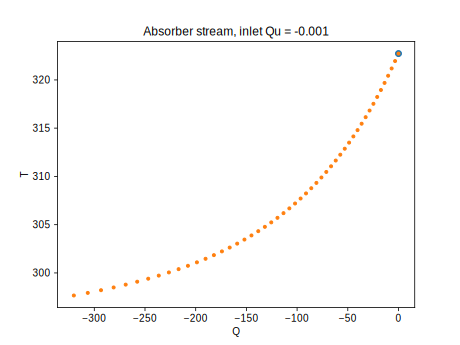

In [83]:
pltsvg()

### Trial 2.2

Just brainstorming ... As a brute-force backup, I would like to have an optimize routine that is a gradient-based method where the gradient calculation and line-search algorithms simply react to passing over the feasible boundary using exceptions instead of constraint functions. (This matters because the total UA constraint function can only be computed when the feasible heat exchange constraints are already satisfied, so in some cases it would have to return infinite values.) In other words, this would be an adaptive step size method. In pseudo-code,

In [ ]:
def optimize(fun,x0,max_iter = 100):
    x = x0.copy()
    for iter in range(max_iter):
        if step == 0:
            break
        G, H = calcGradient(fun, x)
        dx = calcLineSearch(fun, x, G, H)
        x = x + dx
        f = fun(x)
    return x, f

def calcGradient(fun, x0, max_iter = 100):
    max_iter = 100
    # Initial step sizes by component
    deltax = ones_like(x0)
    # Function values to the right
    fplus = zeros_like(x0)
    # Function values to the left
    fminus = zeros_like(x0)
    f0 = fun(x0)
    for j, _ in enumerate(deltax):
        for i in range(max_iter):
            dx = numpy.diag(deltax)[j]
            try:
                xplus = x0 + dx
                xminus = x0 - dx
                fplus[j] = fun(xplus)
                fminus[j] = fun(xminus)
                break
            except:
                deltax[j] *= 0.5
    grad, hess = calcGradHelper(f0, deltax, fplus, fminus) # TODO
    return grad, hess

def calcLineSearch(fun, x0, G, H):
    max_iter = 100
    step = 0
    direction = lshelper1(x0, G, H)
    for i in range(max_iter):
        try:
            lshelper(f
        except:
            step *= 0.5
    return step * direction

#### Aside
Furthermore, here is another related strategy. I could optimize first without the constraint on total UA. That would give me a feasible system. Then, given the desired total UA, I could have a feasible starting point by then turning down the mass flow rate using a linesearch on that parameter.

### Trial 2.3

Another idea (suggested in documention of early trials) is to do something different with the heat exchange feasibility constraints, utilizing energy imbalance. The final goal would be to allow UA values as inputs, and optimize the cooling capacity, as intended. An intermediate goal may be to simply demonstrate a solver with UA values as inputs (using some optimization routine to determine the temperature points that achieve the specified UA values).

# Scratch work

In [15]:
a=5
for i in range(9999):
    a*=0.5
    if a==0:
        break
i,a

(1076, 0.0)

In [25]:
gradient_step = numpy.array([1.,2.,3.,4.])
for j, _ in enumerate(gradient_step):
    for i in range(2):
        gradient_step[j] *= 0.5
gradient_step

array([ 0.25,  0.5 ,  0.75,  1.  ])

In [30]:
numpy.diag(gradient_step)[3]

array([ 0.,  0.,  0.,  1.])

In [50]:
%%html
<pre id="TOC-markdown">TOC will be here</pre>
<script>
$("#TOC-markdown").html(
    $('h1,h2,h3,h4').map(function(){return "  ".repeat($(this).prop("tagName")[1]) + "- ["+$(this).text()+"](" + $(this).children().attr("href") + ")";}).get().join("\n")
    );
</script>